In [1]:
import nibabel as nib
import nilearn.plotting as nplot
import trimesh
import numpy as np
import os
import matplotlib.pyplot as plt
from niworkflows.viz.utils import cuts_from_bbox
import nilearn.image as nimg
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [102]:
# Set up example file
sub = 'sub-UP1UP10206'
scratch = '/scratch/jjeyachandra/niviz/data/'
space = 'T1w'
surf_space = "fsaverage_LR32k"

In [103]:
shortname = {
    "Native": 'native',
    "fsaverage_LR32k": "32k_fs_LR",
    "": "164k_fs_LR"
}
volname = {
    "T1w": "T1w_acpc_dc.nii.gz",
    "MNINonLinear": "T1w.nii.gz"
}
l_surf = nib.load(
    os.path.join(
        scratch, sub, space, surf_space,
    f'{sub}.L.pial.{shortname[surf_space]}.surf.gii'
))
r_surf = nib.load(
    os.path.join(
        scratch, sub, space, surf_space,
    f'{sub}.R.pial.{shortname[surf_space]}.surf.gii'
))

t1 = nib.load(
    os.path.join(
        scratch, sub, space, volname[space]
    )
)

In [104]:
def gifti_get_mesh(gifti):
    '''
    Extract vertices and triangles from GIFTI surf.gii
    file
    
    Arguments:
        gifti (GiftiImage): Input GiftiImage
    '''
    
    v, t = gifti.agg_data(('pointset','triangle'))
    return v.copy(), t.copy()

def gifti_get_full_brain(l, r):
    '''
    Construct a full brain mesh by joining
    both hemispheres
    
    Arguments:
        l: Left hemisphere GiftiImage
        r: Right hemisphere GiftiImage
    '''
    l_vert, l_trig = gifti_get_mesh(l)
    r_vert, r_trig = gifti_get_mesh(r)
    
    
    offset = l_trig.max() + 1
    r_trig += offset
    
    verts = np.vstack((l_vert, r_vert))
    trigs = np.vstack((l_trig, r_trig))
    
    return (verts, trigs, offset)

In [105]:
l_verts, l_trigs = gifti_get_mesh(l_surf)
r_verts, r_trigs = gifti_get_mesh(r_surf)
verts, trigs, offset = gifti_get_full_brain(l_surf, r_surf)

In [106]:
t1.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [107]:
# homogeneous_verts = np.c_[verts,
#                           np.ones((verts.shape[0], 1),dtype=float)]

# # Apply affine
# inv_aff = np.linalg.inv(t1.affine)
# xfm_vert = (inv_aff @ homogeneous_verts.T).T[:,:3]

In [108]:
# Construct mesh
mesh = trimesh.Trimesh(vertices=verts, faces=trigs)

## Updating Nilearn's OrthoSlicer view

In [109]:
from niworkflows.viz.utils import cuts_from_bbox
import nilearn.image as nimg

In [110]:
ncuts = 7

In [111]:
mask_nii = nimg.threshold_img(t1, 1e-3)
cuts = cuts_from_bbox(mask_nii, cuts=ncuts)

In [112]:
sections = mesh.section_multiplane(
    plane_normal=[0,0,1],
    plane_origin=[0,0,0],
    heights=cuts['z']
)

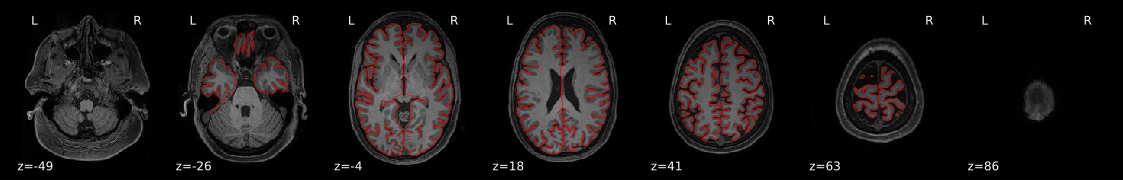

In [113]:
zh = nplot.plot_anat(t1, display_mode='z', cut_coords=cuts['z'])
f = plt.gcf()
a = plt.gca()

for z, s in zip(cuts['z'], sections):
    ax = zh.axes[z].ax
    if s:
        for segs in s.discrete:
            ax.plot(*segs.T, color='r', linewidth=0.5)
            

## Okay weirdness... try again with standard matplotlib?

In [110]:
# Define extent
x1, y1, z1 = t1.shape

AttributeError: 'NoneType' object has no attribute 'discrete'

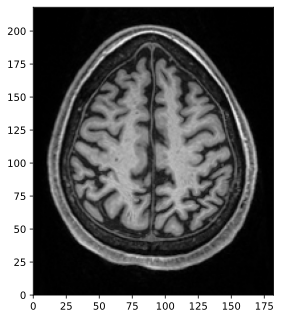

In [111]:
# This works as expected
z = [120]
im = np.rot90(t1.get_fdata()[:,:,z[0]])

f = plt.figure()
ax = f.add_axes([-1,-1,1,1])
plt.imshow(im, cmap='Greys_r', extent=(0, x1, 0, y1))

# Section mesh
sections = mesh.section_multiplane(
    plane_origin=[0, 0, 0],
    plane_normal=[0, 0, 1],
    heights=z
)

for i in sections:
    for j in i.discrete:
        ax.plot(*j.T, color='r')